# Chest X-Ray Medical Diagnosis with Deep Learning

## 1. Imports

- `numpy` and `pandas` for data manipulation
- `matplotlib.pyplot` and `seaborn` for visualization
- `util` utility functions to clean up code

We'll be using Keras and it's built in methods to build our NN model.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model

from skimage import io

import util

import random

In [ ]:
%config InlineBackend.figure_format = 'retina'

## 2. Loading the data
We'll be using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients.
- I've uploaded a sample set of 10K x-ray images to S3 which we'll use shortly.
- Each image in the set contains multiple text labels indicating 14 different conditions which can be used to diagnose 8 different diseases.

The original dataset can be downloaded for free You can download the entire dataset for free [here](https://nihcc.app.box.com/v/ChestXray-NIHCC). 

In [ ]:
train_df = pd.read_csv("nih/train-small.csv")
valid_df = pd.read_csv("nih/valid-small.csv")

test_df = pd.read_csv("nih/test.csv")

train_df.head()

Image  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0  00008270_015.png            0             0              0      0   
1  00029855_001.png            1             0              0      0   
2  00001297_000.png            0             0              0      0   
3  00012359_002.png            0             0              0      0   
4  00017951_001.png            0             0              0      0   

   Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
0         0          0         0       0             0     0       0   
1         1          0         0       0             1     0       0   
2         0          0         0       0             0     0       0   
3         0          0         0       0             0     0       0   
4         0          0         0       0             1     0       0   

   PatientId  Pleural_Thickening  Pneumonia  Pneumothorax  
0       8270                   0          0             0  
1      29855                   0          0             0  
2       1297                   1          0             0  
3      12359                   0          0             0  
4      17951                   0          0             0

In [ ]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

### 2.1 Preventing Data Leakage
We want to make sure that there are no patients in the test set that are exist in the train or validation sets. 

In [ ]:
def check_for_leakage(df1, df2, pt_col):
    """
    Return True if there any patients that are both in df1 and df2.

    Args:
        df1 (dataframe): dataframe describing data set 1
        df2 (dataframe): dataframe describing data set 2
        pt_col (str): name of column with patient IDs
    
    Returns:
        leakage (boolean): True if there is in fact a leakage, otherwise False
    """
    
    df1_pt_unique = set(df1[pt_col].unique().tolist())
    df2_pt_unique = set(df2[pt_col].unique().tolist())
    
    patients_in_both_groups = list(df1_pt_unique.intersection(df2_pt_unique))

    leakage = len(patients_in_both_groups) >= 1
    
    return leakage

<a name='2-2'></a>
### 2.2 Preparing Images

With our dataset splits ready, we can now proceed with setting up our model to consume them. For this we will use the off-the-shelf [ImageDataGenerator](https://keras.io/preprocessing/image/) class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe. 


- We normalize the mean and standard deviation of the data
- We shuffle the input after each epoch.
- We set the image size to be 320px by 320px

In [ ]:
def get_train_generator(train_df, img_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, t_width = 320, t_height = 320):
    """
    Returns generator for training set. 

    Args:
      train_df (dataframe): training df
      image_dir (str): current img directory
      x_col (str): col that holds filenames
      y_cols (list): list of strings that holds labels
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed value
      t_width (int): target width of input.
      t_height (int): target height of input.
    
    Returns:
      generator (DataFrameIterator): iterator over training set
    """        
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    


    # taking the dataframe and the path to a directory + generating batches
    generator = image_generator.flow_from_dataframe(
            dataframe=train_df,
            directory=img_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(t_width,t_height))
    
    return generator

#### Build a separate generator for validation and test sets

Now we need to build a new generator for validation and testing data. This is because we want to normalize one image at a time rather than in batches for test and validation data. In the interest of time, we'll take a sample of the dataset to calculate the meana nd standard deviation rather than all of it. 

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
IMAGE_DIR = "nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

Found 1000 validated image filenames.
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


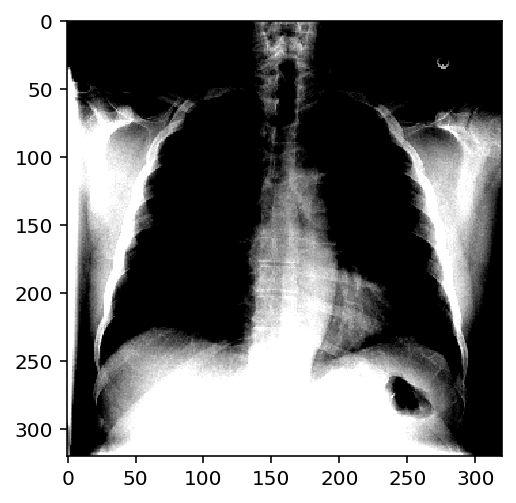

In [ ]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

## 3 Model Development


<a name='3-1'></a>
### 3.1 Addressing Class Imbalance

In [ ]:
fig = go.Figure(data=go.Bar(x = labels, y=np.mean(train_generator.labels, axis=0)))
fig.update_layout(title="<b>Class frequency<b>",
                  template='plotly')

fig.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies.
* The `Hernia` pathology has the greatest imbalance. 
* The `Infiltration` pathology, has 17.5% of the training cases labelled positive.

### Computing Class Frequencies

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients
    N = len(labels)
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - np.sum(labels, axis=0) / N

    return positive_frequencies, negative_frequencies

In [ ]:
# testing class frequency function with currated matrix
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")
print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


In [ ]:
# getting actual class frequencies from data using our function above
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)

In [ ]:
# creating a dataset filter to distinguish between positive and negative labels for each class
negative_label_filter = data[data['Label'] == 'Negative']
positive_label_filter = data[data['Label'] == 'Positive']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=positive_label_filter['Class'],
    y=positive_label_filter['Value'],
    marker_color=px.colors.qualitative.Plotly[5],
    name='Positive',
))

fig.add_trace(go.Bar(
    x=negative_label_filter['Class'],
    y=negative_label_filter['Value'],
    marker_color=px.colors.qualitative.Plotly[0],
    name='Negative',
))

fig.update_layout(barmode='group', title='<b>Class label distribution<b>')
fig.show()

In [ ]:
# displaying png output from previously created fig  (code cell above)
img = io.imread('~/work/src/plots/original_label_distribution.png')
fig = px.imshow(img)
fig.show()

CellOutputSizeError: Cell output is too big.

In [ ]:
# multiplying the frequency for each label in each class by it's weights to get our desired distribution. 
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

## Replotting class label distribution

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(neg_contribution)], ignore_index=True)

negative_label_filter = data[data['Label'] == 'Negative']
positive_label_filter = data[data['Label'] == 'Positive']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=positive_label_filter['Class'],
    y=positive_label_filter['Value'],
    name='Positive',
    marker_color=px.colors.qualitative.Plotly[5],
))

fig.add_trace(go.Bar(
    x=negative_label_filter['Class'],
    y=negative_label_filter['Value'],
    name='Negative',
    marker_color=px.colors.qualitative.Plotly[0],
))


fig.update_layout(barmode='group', title='<b>Updated class label distribution<b>')
fig.show()

### Calculating weighted loss
Great, it's clear that we can correct for the label imbalance issue. We'll write a function that returns a weighted loss function that will calculate the weighted loss given posited and negative weights. This way we won't have to look up the formula more than once!

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, ep=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall loss summed across all classes
        """
        # initializing loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            # adding a small value to the predicted values before taking their logs to avoid possibly dividing by 0.
            loss += (-1 * K.mean(pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + ep)) + (-1 * K.mean(neg_weights[i] * (1 - y_true[:,i]) * K.log(1-y_pred[:,i] + ep))))
        return loss
    
    return weighted_loss

### 3.3 DenseNet Model

To build our model we'll use a [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we loaded from Keras (earlier in the imports) and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers.
2. A `Dense` layer with `sigmoid` activation to get the prediction for each of our classes.

In [ ]:
# create the base pre-trained model
base_model = DenseNet121(weights='./nih/densenet.hdf5', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




## 4 Training

In [ ]:
# callbacks = [
#     K.callbacks.EarlyStopping(patience=10),
#     K.callbacks.ModelCheckpoint(filepath='pretrained_model.h5'),
# ]

# history = model.fit_generator(train_generator, 
#                               validation_data=valid_generator,
#                               steps_per_epoch=100, 
#                               validation_steps=25, 
#                               callbacks = callbacks,
#                               epochs = 100)

# plt.plot(history.history['loss'])
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.title("Training Loss Curve")
# plt.show()

In [ ]:
# load in saved weights 
model.load_weights("./nih/pretrained_model.h5")

<a name='5'></a>
## 5 Prediction and Evaluation

Now that we have a model, let's evaluate it using our test set. We can conveniently use the `predict_generator` function to generate the predictions for the images in our test set.

**Note:** The following cell can take about 4 minutes to run.

In [ ]:
predicted_values = model.predict_generator(test_generator, steps = len(test_generator))

### 5.1 ROC Curve and AUROC
We'll use the pre-defined functions in `utils.py` imported at the begining of the notebook

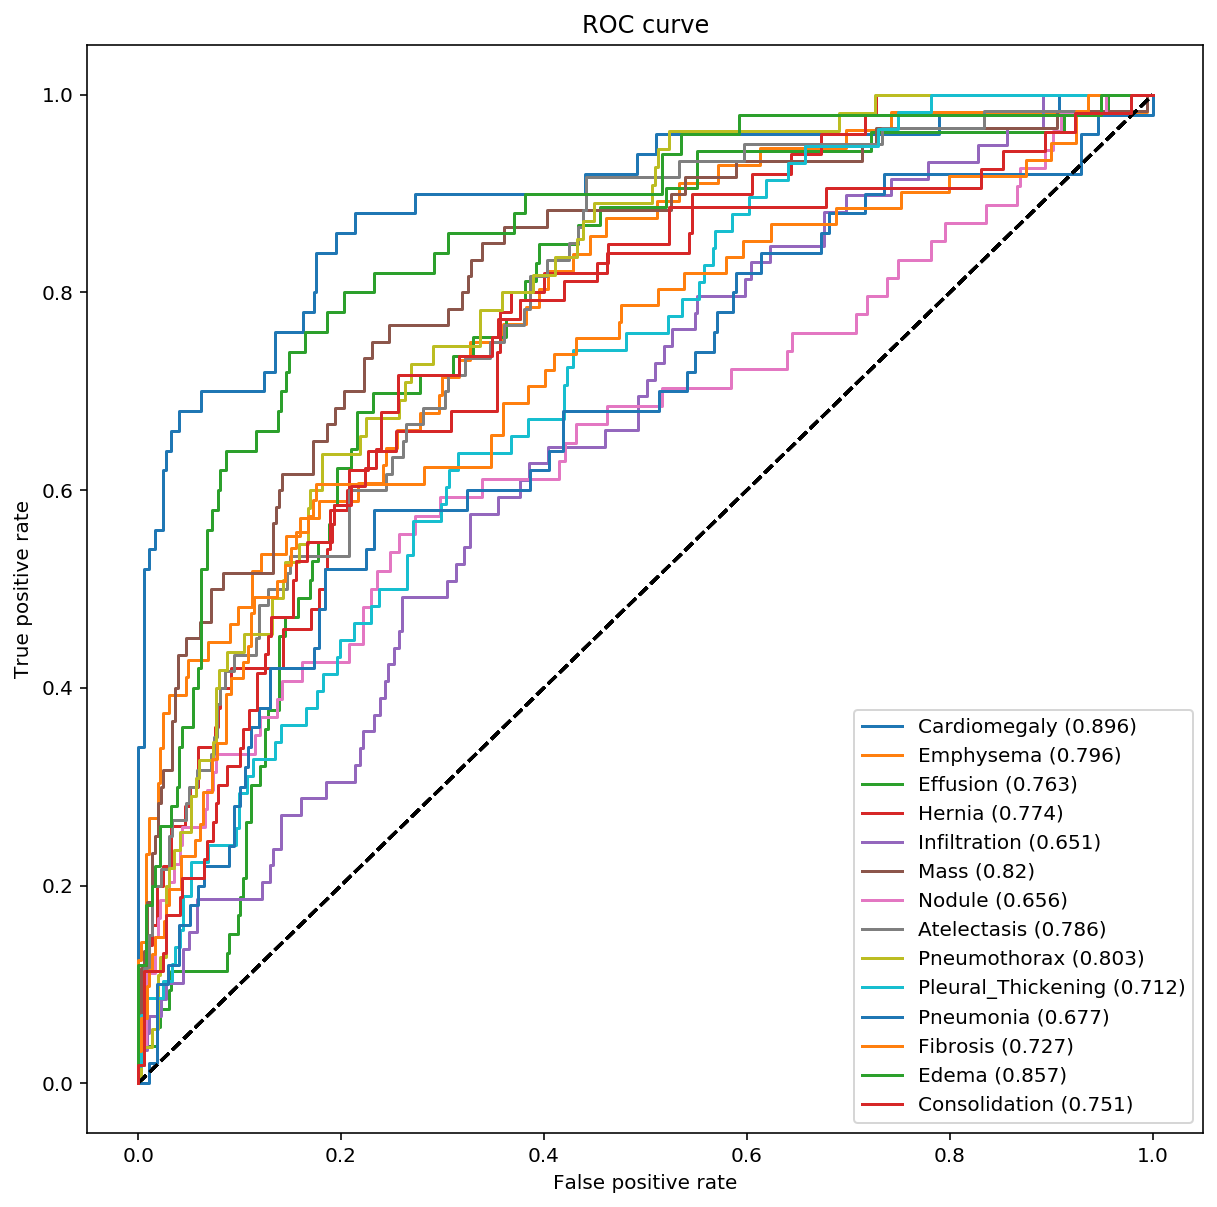

In [ ]:
auc_rocs = util.get_roc_curve(labels, predicted_values, test_generator)

<a name='5-2'></a>
### 5.2 Visualizing Learning with GradCAM 


One of the challenges of using deep learning in medicine is that the complex architecture used for neural networks makes them much harder to interpret compared to traditional machine learning models (e.g. linear models). 

One of the most common approaches aimed at increasing the interpretability of models for computer vision tasks is to use Class Activation Maps (CAM). 
- Class activation maps are useful for understanding where the model is "looking" when classifying an image. 

In this section we will use a [GradCAM's](https://arxiv.org/abs/1610.02391) technique to produce a heatmap highlighting the important regions in the image for predicting the pathological condition. 
- This is done by extracting the gradients of each predicted class, flowing into our model's final convolutional layer. Look at the `util.compute_gradcam` which has been provided for you in `util.py` to see how this is done with the Keras framework. 

It is worth mentioning that GradCAM does not provide a full explanation of the reasoning for each classification probability. 
- However, it is still a useful tool for "debugging" our model and augmenting our prediction so that an expert could validate that a prediction is indeed due to the model focusing on the right regions of the image.

First we will load the small training set and setup to look at the 4 classes with the highest performing AUC measures.

In [ ]:
df = pd.read_csv("nih/train-small.csv")
IMAGE_DIR = "nih/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

Now let's look at a few specific images.

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


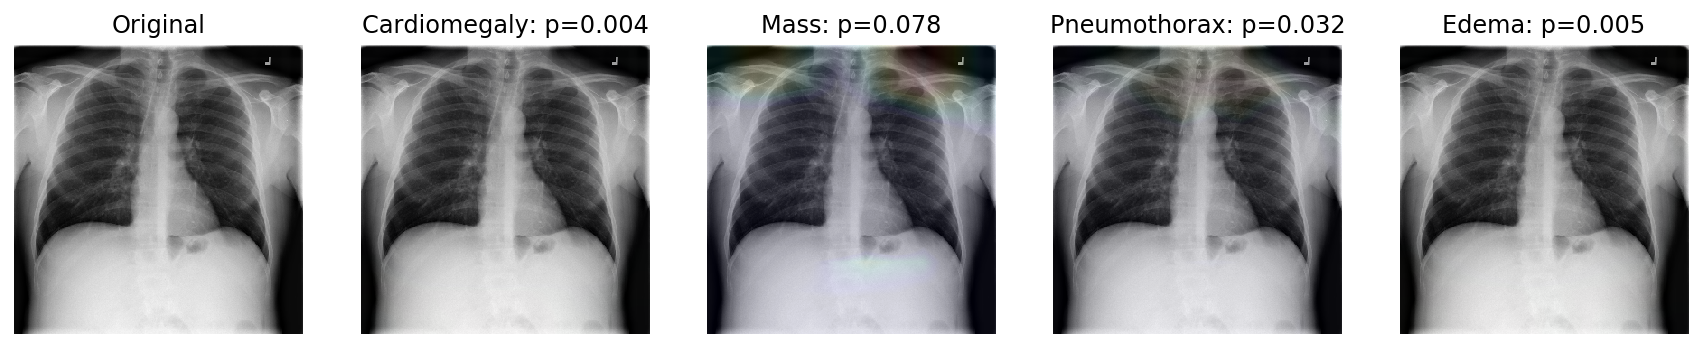

In [ ]:
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


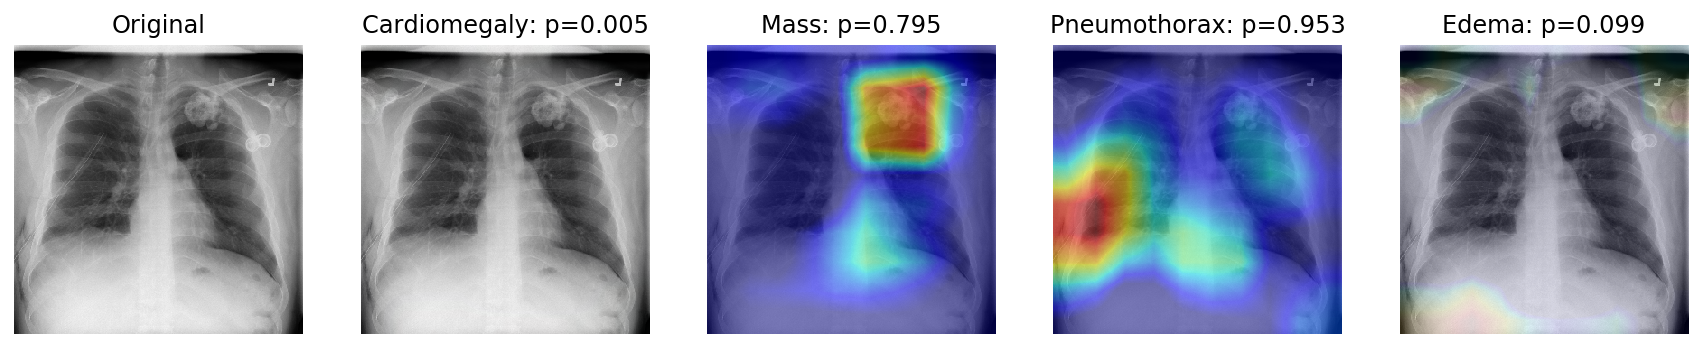

In [ ]:
util.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


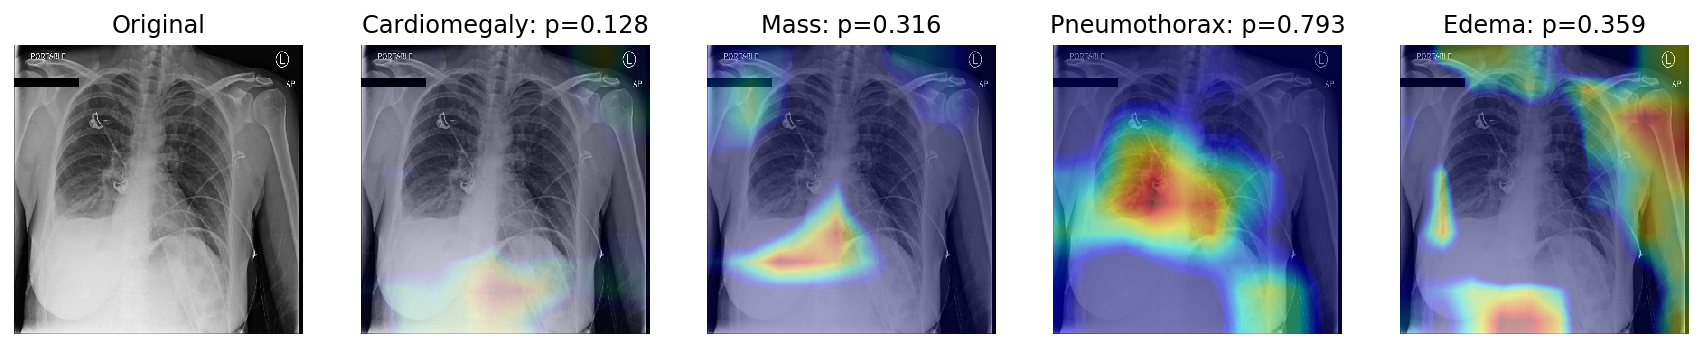

In [ ]:
util.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


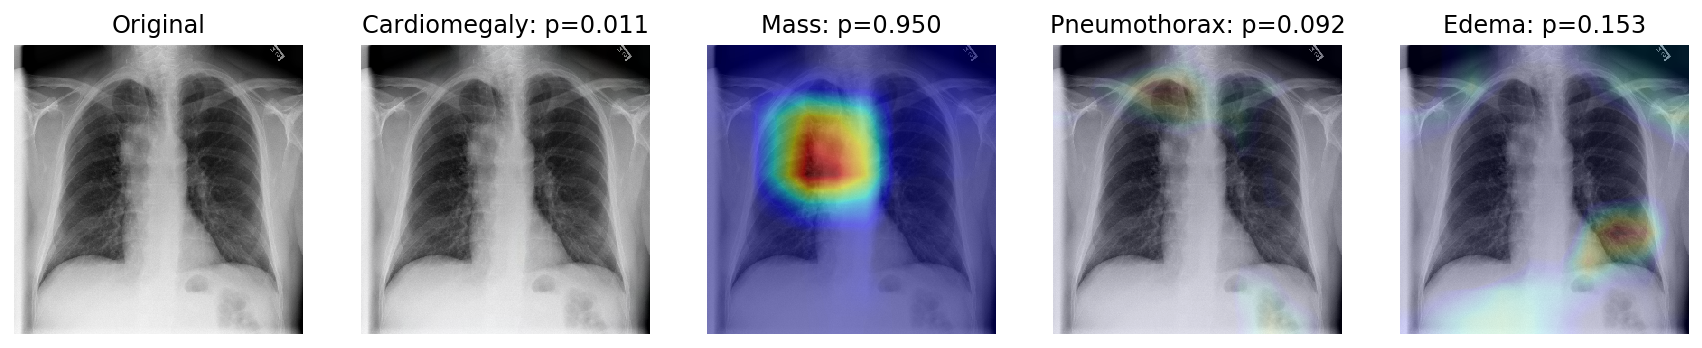

In [ ]:
util.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)

Congratulations, you've completed the first assignment of course one! You've learned how to preprocess data, check for data leakage, train a pre-trained model, and evaluate using the AUC. Great work!